In [1]:
import numpy as np
import gdal
import matplotlib.pyplot as plt
import os
import pandas as pd
import datetime
import bisect
import functools
# from multiprocessing import Pool
import itertools
import pickle as pkl
import time
from IPython.display import clear_output
%matplotlib inline

In [2]:
# read all band images in a directory
images = {}
image_dir = 'earthengine_images/'
for fn in os.listdir(image_dir):
    raw = gdal.Open(image_dir + fn)
    arr = raw.ReadAsArray()
    images[fn.split('.')[0]] = arr

In [3]:
# read all mask images in a directory
masks = {}
mask_dir = 'earthengine_masks/'
for fn in os.listdir(mask_dir):
    raw = gdal.Open(mask_dir + fn)
    arr = raw.ReadAsArray()
    masks[fn.split('.')[0]] = arr

In [4]:
# compose band and mask images into one image
combined = {}
image_dir = 'earthengine_images/'
mask_dir = 'earthengine_masks/'
for fn in os.listdir(image_dir):
    raw_img = gdal.Open(image_dir + fn)
    arr_img = raw_img.ReadAsArray()
    raw_msk = gdal.Open(mask_dir + fn)
    arr_msk = raw_msk.ReadAsArray()
    combined[fn.split('.')[0]] = np.concatenate((arr_img, arr_msk), axis=0)

In [5]:
# use image names to look up metadata from csv export
table = pd.read_csv('earthengine_tables/LC8_SR.csv')
time_start = table[['system:index', 'system:time_start']]

In [6]:
# compose all data into a single data frame
ds = {}
for k, v in combined.items():
    ts = time_start[time_start['system:index'] == k]['system:time_start'].iloc[0]
    ds[ts] = v

In [7]:
t = list(ds.keys())
t.sort()
print(t)

[1423440571231, 1424045737534, 1424822966175, 1426205354132, 1426810523472, 1427587746370, 1428192911630, 1429575310943, 1430352533188, 1430957695975, 1431734919028, 1432340092546, 1433117325195, 1433722502125, 1434499736147, 1435104908414, 1435882143244, 1436487319228, 1437264552573, 1437869725294, 1438646955592, 1439252129269, 1440029363213, 1440634536577, 1441411768125, 1442016943362, 1442794176672, 1443399349500, 1444176579436, 1444781749463, 1445558982533, 1446164155488, 1446941385063, 1447546555861, 1448323787335, 1448928958023, 1449706184998, 1450311357239, 1451088586307, 1451693755106, 1452470982577, 1453076154238, 1453853382683, 1454458551604, 1455235776496, 1456618171987, 1457223342061, 1458000568200, 1458605735131, 1459382957827]


Alternative flow:

In [8]:
def get_boolean_mask(image, level=1):
    cfmask = image[3, :, :]
    cfmask_conf = image[4, :, :]
    return (cfmask == 0) & (cfmask_conf <= level)

In [9]:
def zigzag_integer_pairs(max_x, max_y):
    total = 0
    x = 0
    while total <= max_x + max_y:
        if total - x <= max_y:
            yield (x, total - x)
        if x <= min(max_x - 1, total - 1):
            x += 1
        else:
            total += 1
            x = 0

In [10]:
print([x for x in zigzag_integer_pairs(3, 5)])

[(0, 0), (0, 1), (1, 0), (0, 2), (1, 1), (2, 0), (0, 3), (1, 2), (2, 1), (3, 0), (0, 4), (1, 3), (2, 2), (3, 1), (0, 5), (1, 4), (2, 3), (3, 2), (1, 5), (2, 4), (3, 3), (2, 5), (3, 4), (3, 5)]


In [11]:
def interpolate(timestamp, dataset):
    times = list(dataset.keys())
    times.sort()
    pos = bisect.bisect(times, timestamp)
    n_times = len(times)
    dims = dataset[times[0]].shape
    interpolated = np.zeros((3, dims[1], dims[2]))
    times_before = times[:pos]
    times_before.reverse()
    times_after = times[pos:]
    unfilled = np.ones(dims[1:], dtype=bool)
    for pair in zigzag_integer_pairs(len(times_before) - 1, len(times_after) - 1):
        before = times_before[pair[0]]
        after = times_after[pair[1]]
        alpha = 1.0 * (timestamp - before) / (after - before)
        mask_before = get_boolean_mask(dataset[before])
        mask_after = get_boolean_mask(dataset[after])
        common_unmasked = mask_before & mask_after
        valid = common_unmasked & unfilled
#         fitted = dataset[before][:3, :, :] * alpha + dataset[after][:3, :, :] * (1 - alpha)
        fitted = np.zeros((3, dims[1], dims[2]))
        fitted[:, valid] = dataset[before][:3, valid] * alpha + dataset[after][:3, valid] * (1 - alpha)
        unfilled = unfilled ^ valid
        interpolated[:, valid] = fitted[:, valid]
    # todo: deal with timestamps before the first image or after the last
    # todo: deal with only having masked pixels on one side
    # the above two can be achieved with one-sided value filling
    # interpolate at existing time - remove cloud (should be working already)
    return interpolated

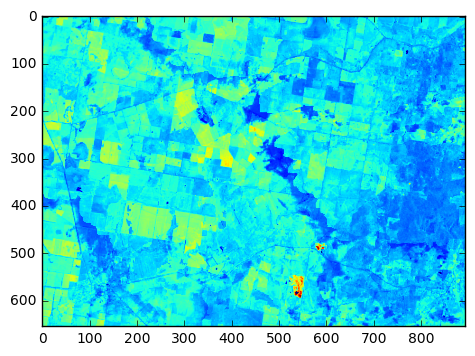

In [12]:
two = int((1450311357239 + 1452470982577) / 2)
res = interpolate(two, ds)
plt.imshow(res[0, :, :])
plt.show()

In [13]:
def interpolate_images(timestamps, dataset):
    return {ts: interpolate(ts, dataset) for ts in timestamps}

In [14]:
times = list(ds.keys())
times.sort()
midpoints = []
for i in range(len(times) - 1):
    midpoints += [int((times[i] + times[i+1]) / 2)]
print(midpoints)

[1423743154382, 1424434351854, 1425514160153, 1426507938802, 1427199134921, 1427890329000, 1428884111286, 1429963922065, 1430655114581, 1431346307501, 1432037505787, 1432728708870, 1433419913660, 1434111119136, 1434802322280, 1435493525829, 1436184731236, 1436875935900, 1437567138933, 1438258340443, 1438949542430, 1439640746241, 1440331949895, 1441023152351, 1441714355743, 1442405560017, 1443096763086, 1443787964468, 1444479164449, 1445170365998, 1445861569010, 1446552770275, 1447243970462, 1447935171598, 1448626372679, 1449317571510, 1450008771118, 1450699971773, 1451391170706, 1452082368841, 1452773568407, 1453464768460, 1454155967143, 1454847164050, 1455926974241, 1456920757024, 1457611955130, 1458303151665, 1458994346479]


In [15]:
fitted_images = interpolate_images(midpoints, ds)

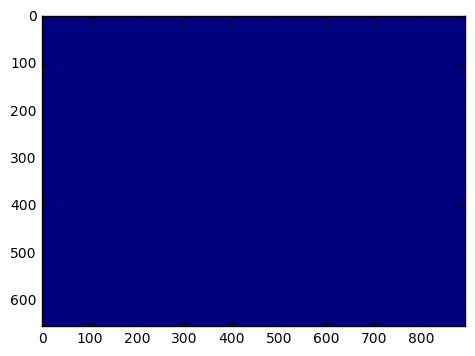

In [16]:
for p in midpoints:
    clear_output()
    plt.imshow(fitted_images[p][0, :, :])
    plt.show()
    time.sleep(0.5)

In [17]:
def convert_to_dataframe(image):
    frame = pd.Panel(image).to_frame()
    return frame

In [18]:
def make_set(images):
    times = list(images.keys())
    times.sort()
    res = pd.concat([convert_to_dataframe(i) for i in images.values()], axis=1, keys=images.keys())
#     res = pd.concat(list(map(convert_to_dataframe, images.values())), axis=0)
    return res.reset_index()

In [19]:
train = make_set(fitted_images)
train.head(10)

major minor 1439640746241                         1432728708870              \
                          0           1           2             0           1   
0     0     0   2994.382239  654.288666  650.818715   3155.499999  729.500000   
1     0     1   3043.984206  640.320850  640.397040   3281.499999  763.000000   
2     0     2   3043.984206  640.320850  640.397040   3352.499999  825.000000   
3     0     3   3148.562531  633.521506  656.176021   3491.500000  841.000000   
4     0     4   3257.735274  621.899176  653.240389   3625.500000  822.000000   
5     0     5   3291.076488  590.634151  637.959273   3656.000000  841.000000   
6     0     6   3298.249230  550.369127  623.726433   3536.500000  730.000000   
7     0     7   3298.249230  550.369127  623.726433   3485.500000  692.000000   
8     0     8   3329.196682  535.260753  613.413132   3305.959202  566.401274   
9     0     9   3392.770736  501.698520  592.569782   3340.545017  554.304700   

              1447935171598             ...     1437567138933 1432037505787  \
            2             0       1     ...                 2             0   
0  714.000000        3111.5  1174.5     ...        756.568680        3069.5   
1  723.000000        3121.0  1091.0     ...        743.897006        3120.5   
2  768.000000        3142.5  1083.0     ...        743.897006        3191.5   
3  791.500000        3127.0  1084.0     ...        785.175979        3233.0   
4  796.500000        3091.0  1085.5     ...        761.240354        3291.0   
5  807.500000        3062.0  1059.0     ...        744.459238        3299.5   
6  724.000000        2982.0  1053.5     ...        712.976404        3151.0   
7  692.000000        2981.5  1065.5     ...        712.976404        3100.0   
8  658.686693        3002.5  1085.0     ...        711.663100        3078.5   
9  638.887330        3000.0  1063.5     ...        686.319752        3170.0   

                1456920757024                          1430655114581  \
       1      2             0            1           2             0   
0  724.5  707.5   2065.214659  1147.618086  900.017210   2528.455004   
1  728.5  694.5   2082.931392  1101.459281  859.296174   2543.111654   
2  790.5  739.5   2082.931392  1101.459281  859.296174   2543.111654   
3  789.0  750.5   2071.369161  1094.334819  848.703903   2627.424955   
4  756.0  742.0   2047.214659  1106.772588  851.892748   2697.266169   
5  755.0  727.0   1994.686771  1097.742548  833.176014   2698.043015   
6  635.0  641.5   1986.652428  1111.021512  848.579441   2661.635297   
7  597.0  609.5   1986.652428  1111.021512  848.579441   2661.635297   
8  574.0  602.5   1975.403504  1118.957130  855.515059   2699.450733   
9  583.5  609.0   1947.618086  1099.613783  828.828365   2746.888500   

                           
            1           2  
0  558.094417  543.278981  
1  560.283252  542.467816  
2  560.283252  542.467816  
3  556.626601  559.433496  
4  554.939902  560.433496  
5  535.909853  541.811165  
6  517.193105  531.124466  
7  517.193105  531.124466  
8  525.660921  536.218883  
9  523.287523  538.094417  

[10 rows x 149 columns]